In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os

import matplotlib.pyplot as plt

path = Path(os.getenv("DATA", "data/"))

# Estimation of Shrinkage Rate and Pool Size

Below is a synthetic dataset of trips generated under the ergodic hypothesis. The dataset contains the following columns:
- `trip_id`: A unique identifyer for a trip
- `crt_id`: A unique identifyer for a crate
- `start`: The start date of the trip
- `end`: The end date of a trip

Trips with `NaT` end values are trips started but not finished. This may be due to a crate being lost or still not having made it back to the SC.

In addition, the dataframe contains the column `state`, with value: 
- `home`, meaning the asset is in a supply center, 
- `rented`, meaning it is within the usable pool, and 
- `lost`, which means that it has reached an end state and will never be recalled to `home`.

This `state` column will allow us to determine the ground truth data for lost assets, but will not be used in the prediction.

In [2]:
df = pd.read_parquet(path / "trips.parquet")

df

,trip_id,crt_id,start,end,state
0,1,1,2019-06-14,2019-10-05,home
1,2,2,2019-06-14,2019-11-16,home
2,3,3,2019-06-14,2019-10-05,home
3,4,4,2019-06-15,2019-11-09,home
4,5,5,2019-06-15,2019-08-27,home
...,...,...,...,...,...
19173,19174,3934,2024-11-25,NaT,rented
19174,19175,3935,2024-11-25,NaT,rented
19175,19176,1148,2024-11-26,NaT,rented
19176,19177,1717,2024-11-26,NaT,rented


<Axes: title={'center': 'Trips by state (Unobservable)'}, ylabel='count'>

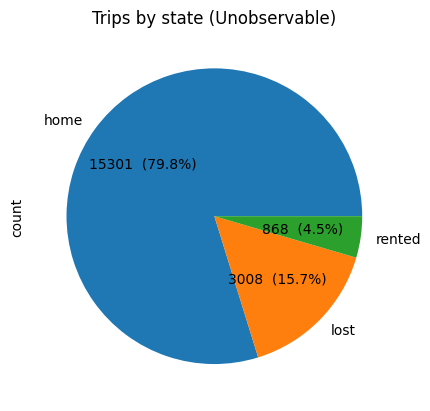

In [3]:

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        return '{v:d}  ({p:.1%})'.format(v=int(pct*total/100), p=pct/100)
    return my_format

counts = df['state'].value_counts()

counts.plot(kind='pie', autopct=autopct_format(counts), title="Trips by state (Unobservable)")

In [4]:
# Let's check the observed trip duration
df['duration'] = (df['end'] - df['start'])
T = df['duration'].mean()
T

Timedelta('96 days 05:07:37.822506862')

Text(0, 0.5, 'Frequency')

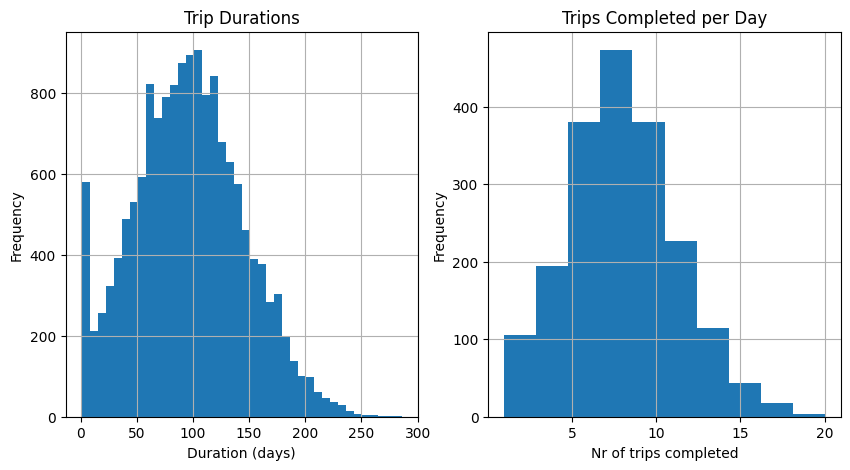

In [5]:
# Look at trip durations

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the distribution of trip durations
df['duration'].dt.days.hist(bins=40, ax=ax[0])

#add title to subplot


ax[0].title.set_text('Trip Durations')
ax[0].set_xlabel('Duration (days)')
ax[0].set_ylabel('Frequency')

# Plot the number of trips completed per day
df['end'].dt.date.value_counts().sort_index().hist(ax=ax[1])
ax[1].title.set_text('Trips Completed per Day')
ax[1].set_xlabel('Nr of trips completed')
ax[1].set_ylabel('Frequency')

### Setup and notation

We call $T$ the average trip duration. We call $x(t)$ the number of ongoing trips at time $t$ and $y(t)$ the number of lost assets up to time $t$. The observed number of unfinished trips at time $t$ is then given by
$$
    z(t) = x(t) + y(t)
$$

The number of trips started at any given date will be $s(t)$ and the number of trips finished will be $f(t)$. The rate of change of $z(t)$ will be
$$
    \dot z(t) = s(t) - f(t),
$$
i.e., the number of new trips minus the number of finished trips.


```mermaid
flowchart LR
    H(Home) --> |s| X(Rented)
    X --> |f| H
    X --> |rx| Y(Lost)
```


### Shrinkage Rate and daily loss rate

The **shrinkage rate**: the probability of an asset not returning from a trip.

We will assume that crates are lost according to the following rules:
- A crate can be lost with equal probability at any time during a trip.
- The loss probability of a crate is independent of the loss of other crates.

This implies that the loss of an asset is a Poisson point process. Under these assumptions, we can draw a series of conclusions:

- The increase rate of $y(t)$ is directly proportional to the number of ongoing trips. The proportionality factor $r$ we'll call the "daily loss rate"
$$
    \dot y(t) = r x(t)
$$
which translates to 
$$
    y(t) = r \int_0^t x(t) dt
$$

- The longer a trip takes, the higher the probability it gets lost. 


The shrinkage rate will depend both on the *daily loss rate* and the average trip duration. The probability that a trip does not end with a return to the *home* state is then given by
$$
    SR = \frac{r}{r + 1/\langle T\rangle}
$$




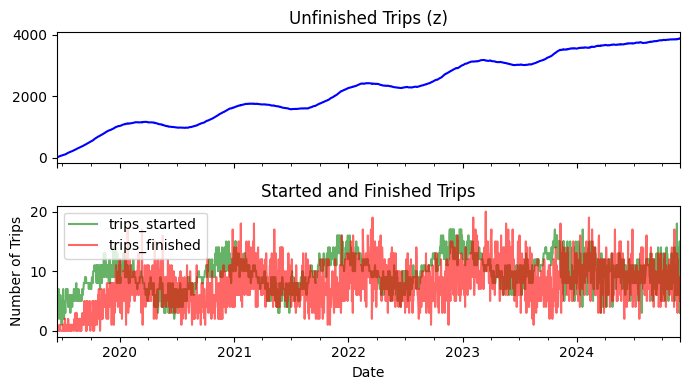

In [6]:
# Create a new dataframe with the count of trips started and finished on each date
daily_df = pd.DataFrame(dict(
    trips_started=df.groupby('start').size(),
    trips_finished=df.groupby('end').size()
)).fillna(0)
daily_df.index.name='date'
daily_df = daily_df.sort_index().reset_index()

# Calculate the number of trips started but not finished on each date
daily_df['unfinished_trips'] = (daily_df['trips_started'] - daily_df['trips_finished']).cumsum()
daily_df.set_index('date', inplace=True)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 4))

daily_df['unfinished_trips'].plot(ax=ax[0], color='blue')

daily_df[['trips_started', 'trips_finished']].plot(ax=ax[1], color=['green', 'red'], alpha=.6)
ax[0].set_title("Unfinished Trips (z)")
ax[1].set_title("Started and Finished Trips")
ax[1].set_ylabel("Number of Trips")
ax[1].set_xlabel("Date")
plt.tight_layout()

## The Erogdic hypothesis
The ergodic hypothesis states that for any observable the ***ensemble average*** equals the ***time average***. For example, the average proportion of assets in a given state $i$ ($f_i$) is proportional to the average time any given asset spends in that state ($\tau_i$):
$$
    \langle \tau_i \rangle_{\rm time} \propto \langle f_i \rangle_{\rm ensemble}
$$

This in turn implies that the number of transitions out of a state $i$ is proportional to the average time spent in $i$, $\langle \tau_i \rangle$.

For our case, the ergodic hypothesis implies (and assuming that the rate at which trips finish is much greater than the rate at which assets get lost)
$$
    f(t) = \frac{x(t)}{\langle T\rangle},
$$
independently of the trip time distribution.

### The Pool Size
Since $f(t)$ is observable, we can deduce that the pool size $x(t)$ is given by 
$$
    x(t) = \langle T \rangle f(t)
$$.



In [7]:
# Define the main quantities

t = T/pd.Timedelta(days=1)
z = daily_df['unfinished_trips']
s = daily_df['trips_started']
f = daily_df['trips_finished']
F = f.cumsum()


In [8]:
# Count the number of crt_id's seen up to a certain date
total = df.groupby('crt_id')['start'].min().reset_index().groupby('start').size().sort_index().cumsum()

estimated_x = t * f
estimated_lost = z - estimated_x
estimated_home = total - estimated_x - estimated_lost

estimated = pd.DataFrame(dict(
    lost=estimated_lost,
    rented=estimated_x,
    home=estimated_home
    )).ffill().rolling(30).mean()

estimated.iloc[-1]

lost      3028.036551
rented     824.230116
home        69.400000
Name: 2024-11-26 00:00:00, dtype: float64

/var/folders/5m/vqkd2l0j2k916b0c3f6bfl4h0000gp/T/ipykernel_71333/3687981122.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set2', len(categories))


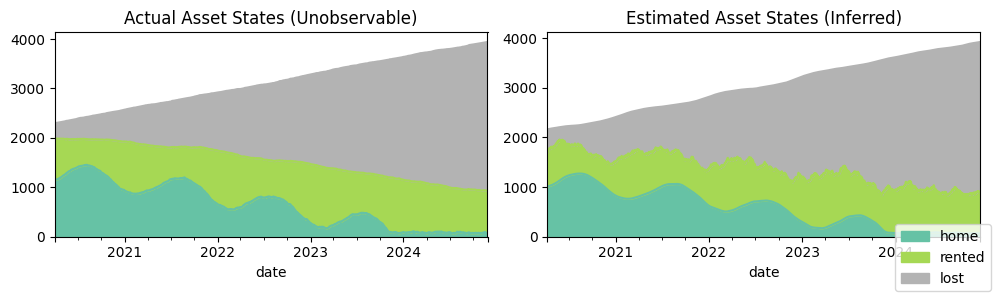

In [9]:
from matplotlib import cm

n = 300

actuals = pd.read_parquet(path / "daily_reports.parquet")

# Extract unique categories
categories = pd.concat([estimated, actuals]).columns[::-1]

# Create a color mapping
colors = cm.get_cmap('Set2', len(categories))
color_mapping = {category: colors(i) for i, category in enumerate(categories)}

# Ensure the same order of categories for stacking
ordered_categories = categories

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

# Plot estimated
estimated[ordered_categories].iloc[n:].plot.area(ax=ax[1], stacked=True, color=[color_mapping[cat] for cat in ordered_categories], legend=False)

# Plot actuals
actuals[ordered_categories].iloc[n:].plot.area(ax=ax[0], stacked=True, color=[color_mapping[cat] for cat in ordered_categories], legend=False)

# Create a shared legend
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')
ax[0].title.set_text('Actual Asset States (Unobservable)')
ax[0].set_xlabel('date')
ax[1].title.set_text('Estimated Asset States (Inferred)')
ax[1].set_xlabel('date')

plt.tight_layout()
plt.show()

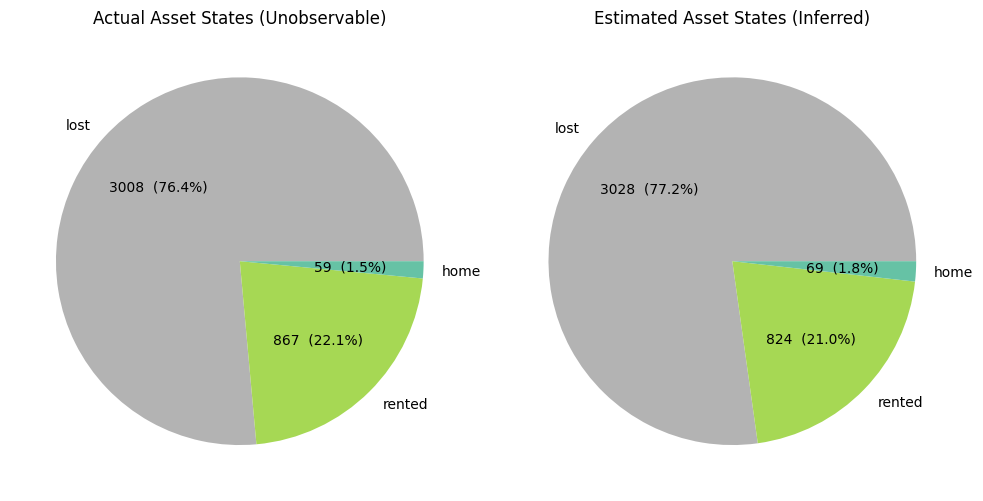

In [10]:
counts = df.groupby('crt_id').last()['state'].value_counts()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pie(counts, labels = counts.index, autopct=autopct_format(counts), colors=colors(np.arange(len(counts))[::-1]))
ax[0].title.set_text('Actual Asset States (Unobservable)')

ax[1].pie(estimated.iloc[-1], labels = estimated.columns, autopct=autopct_format(estimated.iloc[-1]), colors=colors(np.arange(len(estimated.columns))[::-1]))
ax[1].title.set_text('Estimated Asset States (Inferred)')
plt.tight_layout()
plt.show()

### The daily loss rate
Combining the ergodic assumption with the Poissonian distribution of the lost assets means
$$
\begin{align}
    z(t)    & = x(t) + y(t) \\
            & = \langle T\rangle \left (f(t) + r \int_0^t f(\tau) d\tau\right)
\end{align}
$$

So we can obtain
$$
    r = {\left[\frac{z(t)}{ \langle T\rangle} - f(t)\right]}\Bigg/F(t)
$$

where 
$$
    F(t) = {\int_0^t f(\tau) d\tau}
$$
is the total number of completed trips.

### The Shrinkage Rate
$$
    SR = \frac{z(t) - \langle T\rangle f(t)}{z(t) - \langle T\rangle f(t) + F(t)}
$$

In [11]:
# Compute the daily loss rate
sr = (z - t*f)/(z - t*f + F)

SR = 0.1818


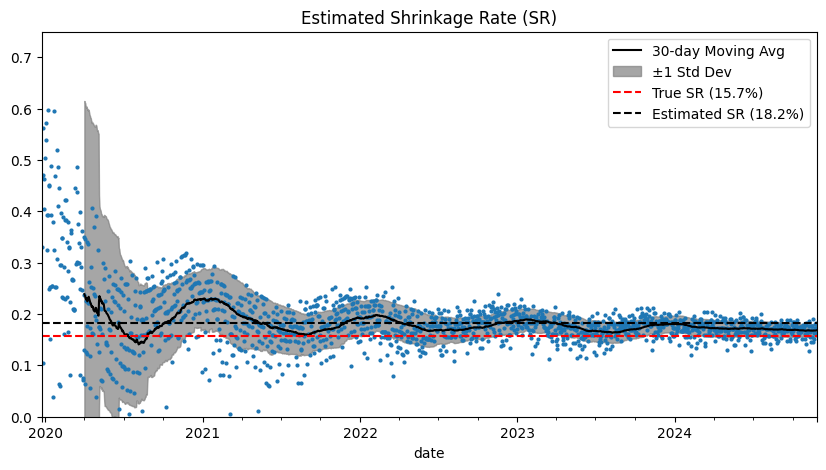

In [12]:
n = 1800

# Discard the early values (transient period)
sr = sr.iloc[-n:]

sr_mean = sr.mean()

print(f"SR = {sr_mean:.4f}")

# Plot the last n values of r with the moving average and the mean and standard deviation
ax = sr.plot(style='o', figsize=(10, 5), markersize=2)

# Compute the rolling mean and standard deviation
rolling_mean = sr.rolling(window=100).mean()
rolling_std = sr.rolling(window=100).std()

# Plot the rolling mean and standard deviation
rolling_mean.plot(ax=ax, color='black', label='30-day Moving Avg')
ax.fill_between(
    sr.index,
    rolling_mean - rolling_std,
    rolling_mean + rolling_std,
    color='gray',
    alpha=0.7,
    label='±1 Std Dev'
)

# Add the true Shrinkage Rate
ax.axhline((df['state'] == 'lost').mean(), color='red', linestyle='--', label=f'True SR ({(df['state'] == 'lost').mean():.1%})')

# Add the estimated Shrinkage Rate
ax.axhline(sr_mean, color='black', linestyle='--', label=f'Estimated SR ({sr_mean:.1%})')

# Add title
ax.set_title("Estimated Shrinkage Rate (SR)")

# Add legend
ax.legend(loc='upper right')
ax.set_ylim(0, 0.75)

fig = ax.get_figure()

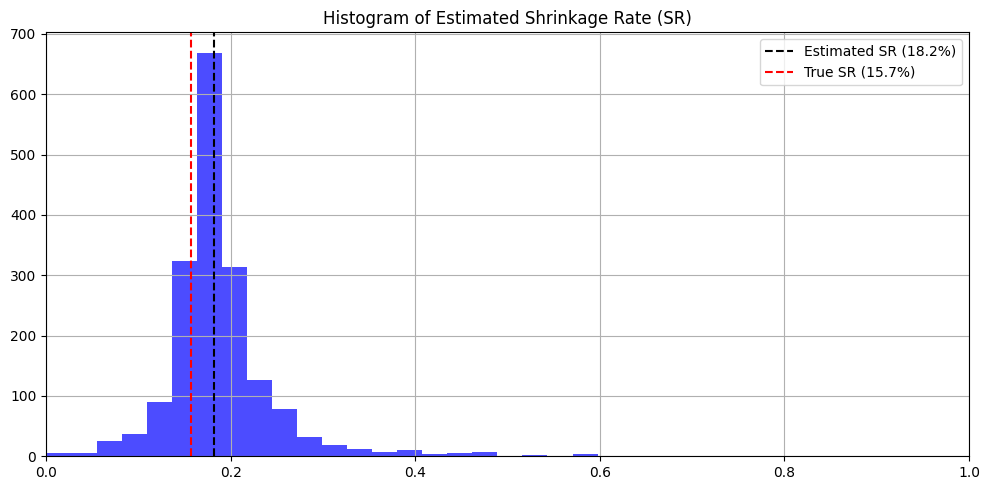

In [13]:
# make a histogram of SR values, the empirical mean and the true value
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sr.hist(ax=ax, bins=120, color='blue', alpha=0.7)
ax.axvline(sr_mean, color='black', linestyle='--', label=f'Estimated SR ({sr_mean:.1%})')
ax.axvline((df['state'] == 'lost').mean(), color='red', linestyle='--', label=f'True SR ({(df['state'] == 'lost').mean():.1%})')
ax.set_title("Histogram of Estimated Shrinkage Rate (SR)")
ax.set_xlim(0, 1)
ax.legend(loc='upper right')
plt.tight_layout()
